# Uncertainty-Aware Wrong Label Prediction in Deep Learning Models for Cyber-Physical System Data

This repository presents the experiments of the paper:

Uncertainty-Aware Wrong Label Prediction in Deep Learning Models for Cyber-Physical System Data

**Importing libraries**

In [1]:
import matplotlib.pyplot as plt
from keras.models import Model, Input
from keras.layers import Dropout,Dense
import pandas as pd
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,accuracy_score,\
    precision_score,recall_score,f1_score
import tqdm
import numpy as np
from sklearn.metrics import confusion_matrix
import seaborn as sns
from scipy.stats import norm
import itertools
from keras.callbacks import ModelCheckpoint
from sklearn.svm import SVC
from mlxtend.plotting import plot_decision_regions
from imblearn.over_sampling import SMOTE
from scipy.stats import entropy

import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report

### Dataset preprocessing

In [2]:
col_names = ['f' + str(i) for i in range(24)]
col_names.append('label')

df = pd.read_csv('robots.zip', skiprows=0, low_memory=False,names=col_names, compression='zip')
class_names = df.label.unique()
df.sample(10)

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f15,f16,f17,f18,f19,f20,f21,f22,f23,label
5269,1.218,1.495,1.271,1.763,1.749,1.749,1.770,2.766,2.746,2.741,...,5.000,0.543,0.539,0.555,1.424,1.387,1.387,1.198,1.201,Move-Forward
3931,1.986,2.555,2.493,2.499,5.000,3.247,3.234,2.881,2.848,2.862,...,0.498,0.916,0.886,0.775,0.826,0.825,0.854,5.000,5.000,Move-Forward
4342,0.900,0.931,1.690,1.668,1.661,1.669,5.000,2.986,2.410,2.849,...,0.624,0.612,0.612,0.640,0.652,0.898,0.882,0.872,0.881,Move-Forward
4512,2.655,2.647,2.654,2.481,1.861,1.336,1.321,1.295,5.000,1.419,...,0.805,5.000,0.913,5.000,0.822,5.000,4.432,3.667,3.701,Sharp-Right-Turn
9,0.458,5.022,3.640,3.644,5.000,2.922,5.000,2.346,2.321,2.628,...,0.590,0.496,0.490,0.498,0.462,0.444,0.458,0.461,0.449,Sharp-Right-Turn
1004,0.602,5.000,5.000,1.313,1.286,1.298,4.744,1.353,5.000,2.926,...,0.848,0.822,0.835,0.857,0.889,0.575,0.588,0.567,0.587,Move-Forward
1315,1.083,5.000,3.242,4.220,5.000,1.918,1.922,1.821,5.000,1.786,...,5.000,0.445,0.445,0.459,0.483,1.036,1.022,1.034,1.058,Sharp-Right-Turn
1182,1.958,2.237,2.164,2.197,5.000,1.894,5.000,2.906,2.895,3.267,...,1.108,1.084,1.102,0.857,0.828,0.786,0.819,0.846,0.872,Move-Forward
1554,0.517,1.407,1.406,1.374,1.386,1.416,1.435,2.613,3.243,3.253,...,0.827,0.837,1.007,5.000,0.475,0.454,0.449,0.457,1.551,Slight-Right-Turn
5257,1.011,2.056,1.979,1.691,1.682,2.074,5.000,1.725,2.340,2.898,...,0.639,0.599,0.599,0.624,0.643,1.226,0.987,0.973,0.982,Move-Forward


In [3]:
y = df.label.values
y = LabelBinarizer().fit_transform(y)
df.drop(["label"], axis=1, inplace=True)

X = df.values
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size=0.33)

## Bayesian Neural Network and Monte Carlo Dropout methods definitions

In [4]:
def get_dropout(input_tensor, p=0.5, mc=False):
    if mc:
        return Dropout(p)(input_tensor, training=True)
    else:
        return Dropout(p)(input_tensor)

def shannon_entropy(vals):
    return -1*np.sum([ val*np.log2(val+0.000000000001) for val in vals])

def get_model(mc=False, act="relu", dropout_size=0.3, num_of_class=2, input_size=2):
    inp = Input(input_size, name='main_input')
    x = Dense(100, activation=act,name='Layer-1')(inp)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(200, activation=act,name='Layer-2')(x)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    x = Dense(100, activation=act,name='Layer-3')(x)
    if mc:
        x = get_dropout(x, p=dropout_size, mc=mc)
    out = Dense(num_of_class, activation='softmax',name='Output-layer')(x)

    model = Model(inputs=inp, outputs=out)
    model.compile(loss="categorical_crossentropy",
                  optimizer="rmsprop",
                  metrics=['accuracy'])

    return model

## Bayesian Neural Network model training

In [5]:
epoch_size = 2000
batch_size = 10000

mcp_save = ModelCheckpoint('robot_model.hdf5', save_best_only=True, monitor='val_accuracy', mode='max')

pred_model_mc = get_model(mc=True, 
                          num_of_class=4, 
                          dropout_size=0.02,
                          input_size=X.shape[1],
                          act="relu")

history_mc = pred_model_mc.fit(X_train, y_train,
              batch_size=batch_size,
              epochs=epoch_size,
              callbacks=[mcp_save],
              verbose=0,
              validation_data=(X_test, y_test))
pred_model_mc.load_weights('robot_model.hdf5')

## Plot training history for accuracy and loss

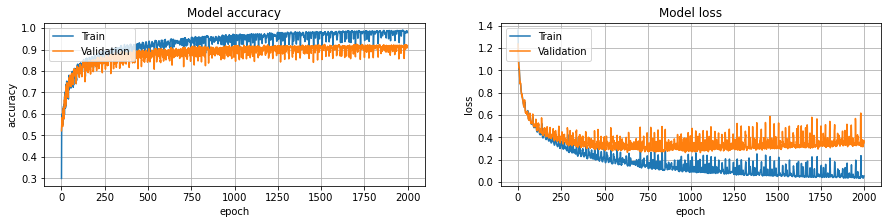

In [6]:
plots = ['accuracy','loss']
i = 0
fig = plt.figure(figsize=(15, 3))
for plot_type in plots:
    ax = fig.add_subplot(1, 2, i+1)
    ax.plot(history_mc.history[plot_type])
    ax.plot(history_mc.history['val_' + plot_type])
    ax.set_title('Model ' + plot_type)
    ax.set_ylabel(plot_type)
    ax.set_xlabel('epoch')
    ax.legend(['Train', 'Validation'], loc='upper left')
    ax.grid(True)
    i =+ 1
plt.show()

# 

## Let's find the uncertainty values of the each test dataset

In [7]:
# Monte carlo predictions
mc_predictions = []
for i in tqdm.tqdm(range(200)):
    y_p = pred_model_mc.predict(X_test, batch_size=1000)
    mc_predictions.append(y_p)

max_means = []
preds = []
entropy_vals = []
std_vals = []
for idx in range(X_test.shape[0]):
    px = np.array([p[idx] for p in mc_predictions])
    #print(px.max(axis=1))
    preds.append(px.mean(axis=0).argmax())
    max_means.append(px.mean(axis=0).max())
    prob_dist = []
    for i, (prob, var) in enumerate(zip(px.mean(axis=0), px.std(axis=0))):
        prob_dist.append(prob)
    entropy_vals.append(shannon_entropy(prob_dist))
    #entropy_vals.append(entropy(prob_dist, base=2))
    std_vals.append(np.std(px.max(axis=1)))

unc_ent_idx = np.flip((np.array(entropy_vals)).argsort()[-3:])
unc_std_idx = np.flip((np.array(std_vals)).argsort()[0:3])

100%|██████████| 200/200 [00:10<00:00, 19.84it/s]


## Research Questions
We aim to explore uncertainty quantification using the Bayesian neural network with the entropy and Softmax prediction probability variance methods. So we form the following Research Questions (RQs) and design the experiments to answer them: 
- **RQ1** How can the model's decision making be characterized with uncertainty quantification?
- **RQ2** Is there any correlation between uncertainty and classification performance?
- **RQ3** How can the model's false labelling be predicted by another model using the uncertainty values?
- **RQ4** What is the best strategy for the best dropout ratio?

### RQ1: How can the model's decision making be characterized with uncertainty quantification?

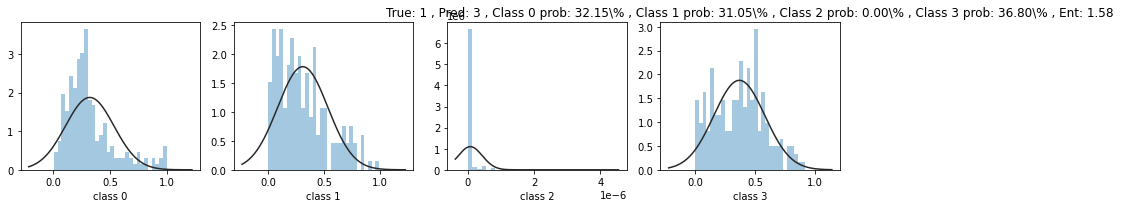

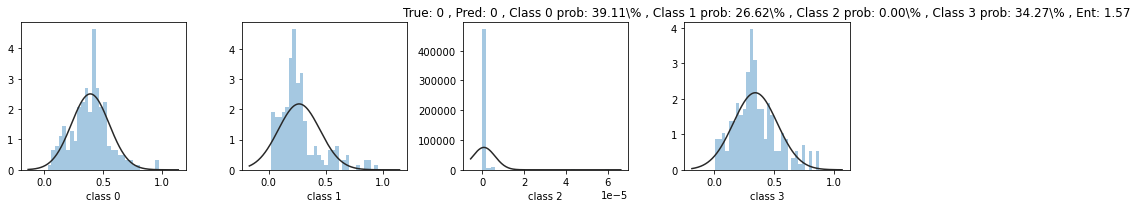

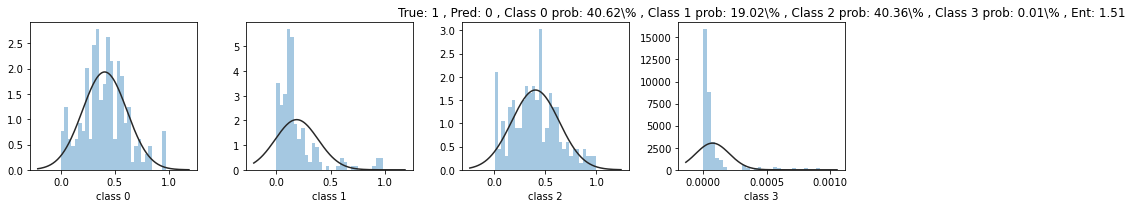

In [8]:
for idx_iter in range(3):
    idx = unc_ent_idx[idx_iter]
    p0 = np.array([p[idx] for p in mc_predictions])
    prob_txt = []
    prob_txt.append("True: {}".format(y_test[idx].argmax()))
    prob_txt.append(", Pred: {}".format(p0.mean(axis=0).argmax()))

    prob_dist = []

    for i, (prob, var) in enumerate(zip(p0.mean(axis=0), p0.std(axis=0))):
        prob_txt.append(", Class {} prob: {:2.2f}\%".format(i, prob*100))
        prob_dist.append(prob)
    prob_txt.append(", Ent: {:.2f}".format(shannon_entropy(prob_dist)))

    prob_txt = " ".join(prob_txt).strip()
    fig, axes = plt.subplots(1, 4, figsize=(12,3))

    for i, ax in enumerate(fig.get_axes()):
        sns.distplot( p0[:,i],ax=ax, bins=30, fit=norm, kde=False)
        ax.set_xlabel(f"class {i}")

    plt.title(prob_txt)
    fig.tight_layout()
    
    plt.show()

### RQ2: Is there any correlation between uncertainty and classification performance?

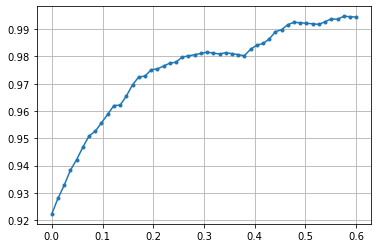

In [9]:
df_results = pd.DataFrame(data = X_test,
                  columns=['f' + str(i) for i in range(X_test.shape[1])])
df_results['y'] = y_test.argmax(axis=1)
df_results['y_hat'] = preds
df_results['unc_entropy'] = entropy_vals
df_results['unc_std'] = std_vals

discarded_ratio_list = np.linspace(0,0.6,num=50)

df_results.sort_values(by=['unc_entropy'],ascending=True,inplace=True)

acc_list = []
for discarded_ratio in discarded_ratio_list:
    tmp_df = df_results.head(np.int(df_results.shape[0] * (1-discarded_ratio)))
    y = tmp_df.y.values
    y_hat = tmp_df.y_hat.values
    acc_list.append(accuracy_score(y,y_hat))
plt.plot(discarded_ratio_list,acc_list, '-', marker = '.')
plt.grid()
plt.show()

In [10]:
cr = classification_report(df_results.y,df_results.y_hat)
print(cr)

              precision    recall  f1-score   support

           0       0.90      0.92      0.91       712
           1       0.95      0.95      0.95       707
           2       0.91      0.88      0.89       116
           3       0.91      0.87      0.89       266

    accuracy                           0.92      1801
   macro avg       0.92      0.91      0.91      1801
weighted avg       0.92      0.92      0.92      1801



### RQ3: How can the model's false labelling be predicted by another model using the uncertainty values?

              precision    recall  f1-score   support

           0       0.66      0.97      0.79       500
           1       0.00      0.00      0.00       250

    accuracy                           0.65       750
   macro avg       0.33      0.48      0.39       750
weighted avg       0.44      0.65      0.52       750



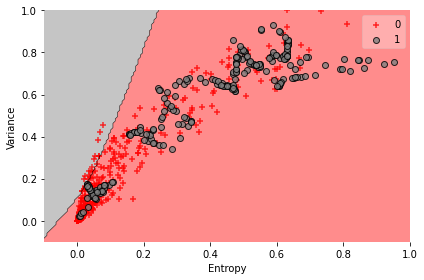

In [11]:
oversample = SMOTE(sampling_strategy=0.5)

X_unc = np.stack((entropy_vals,std_vals),axis=1)
scaler = MinMaxScaler()
X_unc = scaler.fit_transform(X_unc)

mc_ensemble_pred = np.array(mc_predictions).mean(axis=0).argmax(axis=1)
wrong_labels = np.abs(y_test.argmax(axis=1) - mc_ensemble_pred)
wrong_labels[np.where(wrong_labels > 0)] = 1

X_w_train, X_w_test, y_w_train, y_w_test = train_test_split(X_unc, wrong_labels, 
                                                    test_size=0.7)

X_w_train, y_w_train = oversample.fit_resample(X_w_train, y_w_train)

clf = SVC(gamma=1000,kernel='poly',C=1000,tol=1e-14, max_iter=1e8)
clf.fit(X_w_train, y_w_train)

y_pred = clf.predict(X_w_train)
cr = classification_report(y_w_train, y_pred)
print(cr)

ax = plot_decision_regions(X_w_train, y_w_train, clf=clf, legend=1,
                      markers='+o',hide_spines=True,colors='red,gray')
plt.xlim((-0.1,1.0))
plt.ylim((-0.1,1.0))
plt.xlabel('Entropy')
plt.ylabel('Variance')
plt.tight_layout()

In [12]:
cr = classification_report(y_w_train, y_pred)
print(cr)

              precision    recall  f1-score   support

           0       0.66      0.97      0.79       500
           1       0.00      0.00      0.00       250

    accuracy                           0.65       750
   macro avg       0.33      0.48      0.39       750
weighted avg       0.44      0.65      0.52       750



### RQ4: What is the best strategy for the best dropout ratio?

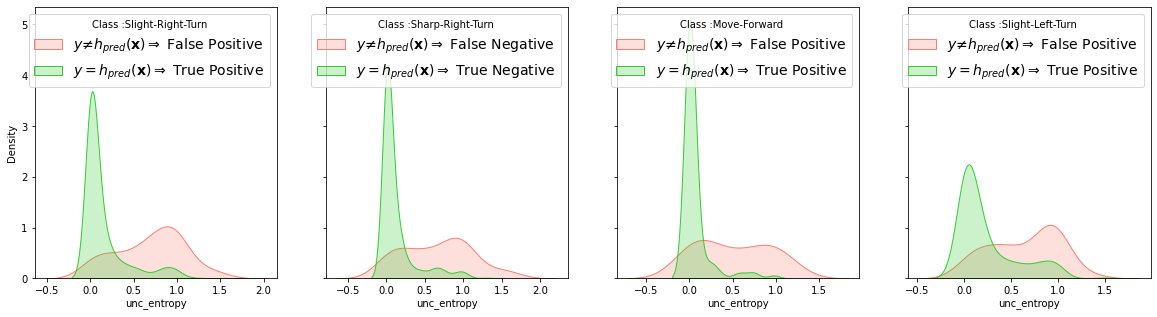

In [13]:
num_of_class = 4
fig, axes = plt.subplots(1, num_of_class, figsize=(20, 5), sharey=True)
for i in range(num_of_class):
    kde_plot_title = ' Positive'
    if i == 1:
        kde_plot_title = ' Negative'

    subset = df_results.query('y==' + str(i) + ' and y_hat!=' + str(i))
    sns.distplot(subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="salmon",
                 label = r'$y \ne h_{pred}(\mathbf{x}) \Rightarrow$ False' + kde_plot_title)
    
    subset = df_results.query('y==' + str(i) + ' and y_hat==' + str(i))
    sns.distplot( subset['unc_entropy'], hist = False, kde = True,
                 kde_kws = {'linewidth': 1, 'shade': True},ax=axes[i],
                 hist_kws=dict(alpha=1),color="limegreen",
                 label = '$y = h_{pred}(\mathbf{x}) \Rightarrow$ True' + kde_plot_title)
    axes[i].legend(prop={'size': 14}, 
                           title = 'Class :' + class_names[i])